<a href="https://colab.research.google.com/github/MMasoJR/CS04-RedesNeurais/blob/main/CS4_Redes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
# -------------------------------------------------------------------
# INSTALAÇÃO E IMPORTS
# -------------------------------------------------------------------
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Configurações do Matplotlib
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)

In [15]:
# -------------------------------------------------------------------
# CARREGAR OS DADOS
# -------------------------------------------------------------------
# Faça o upload manual do arquivo usando o ícone de pasta na barra lateral esquerda do Colab
# O arquivo pode ser encontrado em: https://www.gov.br/prf/pt-br/acesso-a-informacao/dados-abertos/dados-abertos-da-prf,
# Como: 'Documento CSV de Acidentes 2024 (Agrupados por pessoa - Todas as causas e tipos de acidentes)'
# Mude o nome do arquivo para: 'acidentes2024.csv'

# Tenta carregar o arquivo
try:
    df_raw = pd.read_csv('acidentes2024.csv', encoding='latin-1', sep=';')
    print(f"Dados carregados com sucesso. {df_raw.shape[0]} linhas e {df_raw.shape[1]} colunas.")
except FileNotFoundError:
    print("ERRO: 'acidentes2024.csv' não encontrado.")
except Exception as e:
    print(f"Erro ao ler o CSV: {e}")

Dados carregados com sucesso. 603215 linhas e 37 colunas.


In [20]:
# -------------------------------------------------------------------
# SELEÇÃO DE FEATURES
# -------------------------------------------------------------------
colunas_selecionadas = [
    'id', # Necessário para contar n_acidentes
    'data_inversa',
    'dia_semana',
    'horario',
    'fase_dia',
    'uf',
    'br',
    'km',
    'causa_acidente',
    'tipo_acidente',
    'condicao_metereologica',
    'tipo_pista',
    'classificacao_acidente',
    'mortos',
    'feridos_graves',
    'feridos_leves',
]

df = df_raw[colunas_selecionadas].copy()
print(f"DataFrame focado com {df.shape[1]} colunas.")

DataFrame focado com 16 colunas.


In [21]:
# -------------------------------------------------------------------
# LIMPEZA E PRÉ-PROCESSAMENTO
# -------------------------------------------------------------------

# Converter data e definir como índice
df['data'] = pd.to_datetime(df['data_inversa'], format='%Y-%m-%d')
df = df.set_index('data')

# Converter colunas numéricas e preencher NaNs
    # Converter 'horario' para hora numérica (0-23)
df['horario'] = pd.to_datetime(df['horario'], format='%H:%M:%S', errors='coerce').dt.hour
    # Converter 'km' para numérico
df['km'] = pd.to_numeric(df['km'].astype(str).str.replace(',', '.'), errors='coerce')

num_cols = ['horario', 'km', 'mortos', 'feridos_graves', 'feridos_leves']
df[num_cols] = df[num_cols].fillna(0)

# 3. Preencher NaNs em colunas categóricas
cat_cols = [
    'dia_semana', 'fase_dia', 'uf', 'br', 'causa_acidente',
    'tipo_acidente', 'condicao_metereologica', 'tipo_pista', 'classificacao_acidente'
]
df[cat_cols] = df[cat_cols].fillna('Desconhecido')

print("Dados limpos e colunas convertidas.")
df.info()

Dados limpos e colunas convertidas.
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 603215 entries, 2024-01-01 to 2024-12-10
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      603215 non-null  float64
 1   data_inversa            603215 non-null  object 
 2   dia_semana              603215 non-null  object 
 3   horario                 603215 non-null  int32  
 4   fase_dia                603215 non-null  object 
 5   uf                      603215 non-null  object 
 6   br                      603215 non-null  object 
 7   km                      603215 non-null  float64
 8   causa_acidente          603215 non-null  object 
 9   tipo_acidente           603215 non-null  object 
 10  condicao_metereologica  603215 non-null  object 
 11  tipo_pista              603215 non-null  object 
 12  classificacao_acidente  603215 non-null  object 
 13  mortos                

In [22]:
# -------------------------------------------------------------------
# AGREGAÇÃO TEMPORAL (Transformar em Série Temporal)
# -------------------------------------------------------------------
# Função para agregar pelo valor mais comum (Moda)
def aggregate_mode(series):
    return series.mode()[0] if not series.empty else 'Desconhecido'

# Dicionário de agregação
agg_dict = {
    # Target (Contagem)
    'id': 'count',
    # Features Numéricas
    'horario': 'mean', # Média da hora dos acidentes
    'km': 'mean',      # Média do KM dos acidentes
    'mortos': 'sum',
    'feridos_graves': 'sum',
    'feridos_leves': 'sum',
    # Features Categóricas (pegar a mais comum do dia)
    'dia_semana': aggregate_mode,
    'fase_dia': aggregate_mode,
    'uf': aggregate_mode,
    'br': aggregate_mode,
    'causa_acidente': aggregate_mode,
    'tipo_acidente': aggregate_mode,
    'condicao_metereologica': aggregate_mode,
    'tipo_pista': aggregate_mode,
    'classificacao_acidente': aggregate_mode,
}

# Aplicar agregação diária
df_daily = df.resample('D').agg(agg_dict)

# Renomear o target e reordenar para ser a primeira coluna
df_daily = df_daily.rename(columns={'id': 'n_acidentes'})
cols_order = ['n_acidentes'] + [col for col in df_daily.columns if col != 'n_acidentes']
df_daily = df_daily[cols_order]

print("Dados agregados por dia:")
df_daily.head()

Dados agregados por dia:


,n_acidentes,horario,km,mortos,feridos_graves,feridos_leves,dia_semana,fase_dia,uf,br,causa_acidente,tipo_acidente,condicao_metereologica,tipo_pista,classificacao_acidente
data,,,,,,,,,,,,,,,
2024-01-01,1898,12.851949,282.606270,68.0,253.0,753.0,segunda-feira,Pleno dia,MG,101.0,Velocidade Incompatível,Saída de leito carroçável,Chuva,Simples,Com Vítimas Feridas
2024-01-02,2378,13.550463,278.006476,73.0,226.0,907.0,terça-feira,Pleno dia,SC,101.0,Reação tardia ou ineficiente do condutor,Saída de leito carroçável,Chuva,Simples,Com Vítimas Feridas
2024-01-03,1725,12.748406,288.651768,69.0,140.0,682.0,quarta-feira,Pleno dia,MG,153.0,Ausência de reação do condutor,Saída de leito carroçável,Céu Claro,Simples,Com Vítimas Feridas
2024-01-04,1396,12.535100,260.694842,53.0,248.0,446.0,quinta-feira,Pleno dia,SC,101.0,Reação tardia ou ineficiente do condutor,Colisão traseira,Céu Claro,Simples,Com Vítimas Feridas
2024-01-05,1300,13.201538,283.257462,59.0,114.0,436.0,sexta-feira,Pleno dia,SC,101.0,Reação tardia ou ineficiente do condutor,Saída de leito carroçável,Céu Claro,Simples,Com Vítimas Feridas


In [29]:
# -------------------------------------------------------------------
# ENCODING E SCALING
# -------------------------------------------------------------------
# Tratar os dados agregados
df_processed = df_daily.copy()

# 1. Label Encoding para colunas categóricas
cat_cols_agg = [
    'dia_semana', 'fase_dia', 'uf', 'br', 'causa_acidente',
    'tipo_acidente', 'condicao_metereologica', 'tipo_pista', 'classificacao_acidente'
]

for col in cat_cols_agg:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))

# 2. Lidar com possíveis NaNs da agregação (Dias sem acidentes)
df_processed = df_processed.fillna(0)

# 3. Scaling (Normalizar todas as features juntas)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df_processed)

n_features = data_scaled.shape[1]
target_col_index = 0 # 'n_acidentes' é a coluna 0

print(f"DataFrame final processado para LSTM (Total de Features: {n_features})")
print(pd.DataFrame(data_scaled, columns=df_processed.columns).head())

DataFrame final processado para LSTM (Total de Features: 15)
   n_acidentes   horario        km    mortos  feridos_graves  feridos_leves  \
0     0.311192  0.531577  0.327680  0.049822        0.268116       0.468065   
1     0.456779  0.610172  0.311613  0.054270        0.228986       0.614871   
2     0.258720  0.519926  0.348798  0.050712        0.104348       0.400381   
3     0.158932  0.495925  0.251142  0.036477        0.260870       0.175405   
4     0.129815  0.570912  0.329955  0.041815        0.066667       0.165872   

   dia_semana  fase_dia        uf    br  causa_acidente  tipo_acidente  \
0    0.500000       1.0  0.263158  0.04             1.0          0.875   
1    1.000000       1.0  0.894737  0.04             0.8          0.875   
2    0.166667       1.0  0.263158  0.20             0.2          0.875   
3    0.333333       1.0  0.894737  0.04             0.8          0.625   
4    0.666667       1.0  0.894737  0.04             0.8          0.875   

   condicao_metereo

In [30]:
# -------------------------------------------------------------------
# CRIAÇÃO DE SEQUÊNCIAS (JANELAS)
# -------------------------------------------------------------------
window_size = 7

X, y = [], []
for i in range(len(data_scaled) - window_size):
    # X = Janela de 'window_size' dias com todas as 'n_features'
    X.append(data_scaled[i:(i + window_size), :])

    # y = Apenas o 'n_acidentes' (coluna 'target_col_index') do dia seguinte
    y.append(data_scaled[i + window_size, target_col_index])

X = np.array(X)
y = np.array(y)

print(f"Formato de X: {X.shape}") # (Samples, Timesteps, Features)
print(f"Formato de y: {y.shape}") # (Samples,)

Formato de X: (359, 7, 15)
Formato de y: (359,)


In [31]:
# -------------------------------------------------------------------
# DIVISÃO TREINO/TESTE
# -------------------------------------------------------------------
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Formato X_train: {X_train.shape}")
print(f"Formato X_test: {X_test.shape}")

Formato X_train: (287, 7, 15)
Formato X_test: (72, 7, 15)


In [40]:
# -------------------------------------------------------------------
# CONSTRUÇÃO DO MODELO LSTM
# -------------------------------------------------------------------
# A arquitetura precisa do 'input_shape' com as 15 features
model = Sequential()
model.add(LSTM(
    units=30,
    activation='relu',
    return_sequences=True,
    input_shape=(window_size, n_features)
))
model.add(Dropout(0.3))

model.add(LSTM(
    units=30,
    activation='relu'
))
model.add(Dropout(0.3))

model.add(Dense(units=1)) # Saída: previsão de 'n_acidentes'

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 7, 30)          │         5,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 30)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 30)             │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,871 (50.28 KB)

 Trainable params: 12,871 (50.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.1077 - val_loss: 0.0363
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0237 - val_loss: 0.0234
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0249 - val_loss: 0.0244
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0187 - val_loss: 0.0280
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0162 - val_loss: 0.0249
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0166 - val_loss: 0.0234
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0171 - val_loss: 0.0236
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0158 - val_loss: 0.0235
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0171 - val_loss: 0.0246
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0148 - val_loss: 0.0228
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0137 - val_loss: 0.0230
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0136 - val_loss: 0.0232
E

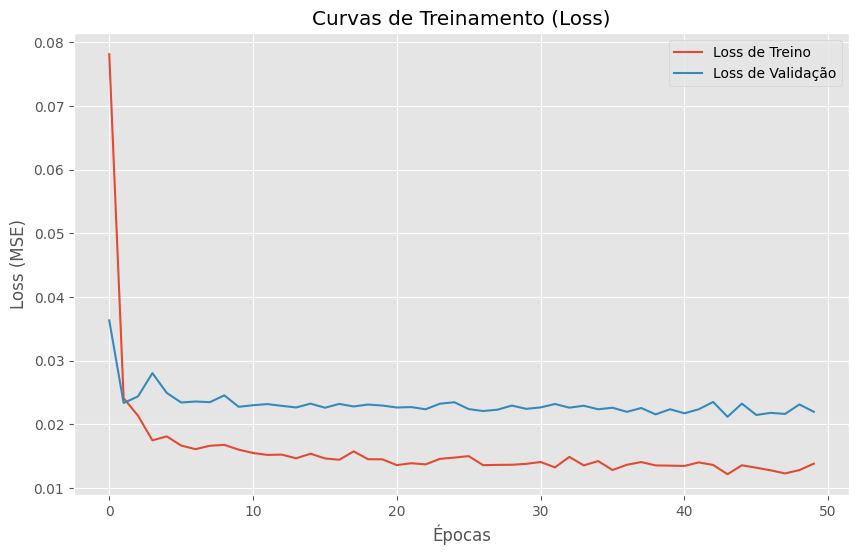

In [41]:
# -------------------------------------------------------------------
# TREINAMENTO E GRÁFICOS DE LOSS
# -------------------------------------------------------------------
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Plotar curvas de treinamento (Loss)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Loss de Treino')
plt.plot(history.history['val_loss'], label='Loss de Validação')
plt.title('Curvas de Treinamento (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
--- Métricas de Avaliação no Conjunto de Teste ---
RMSE (Root Mean Squared Error): 488.67
MAE (Mean Absolute Error): 335.06


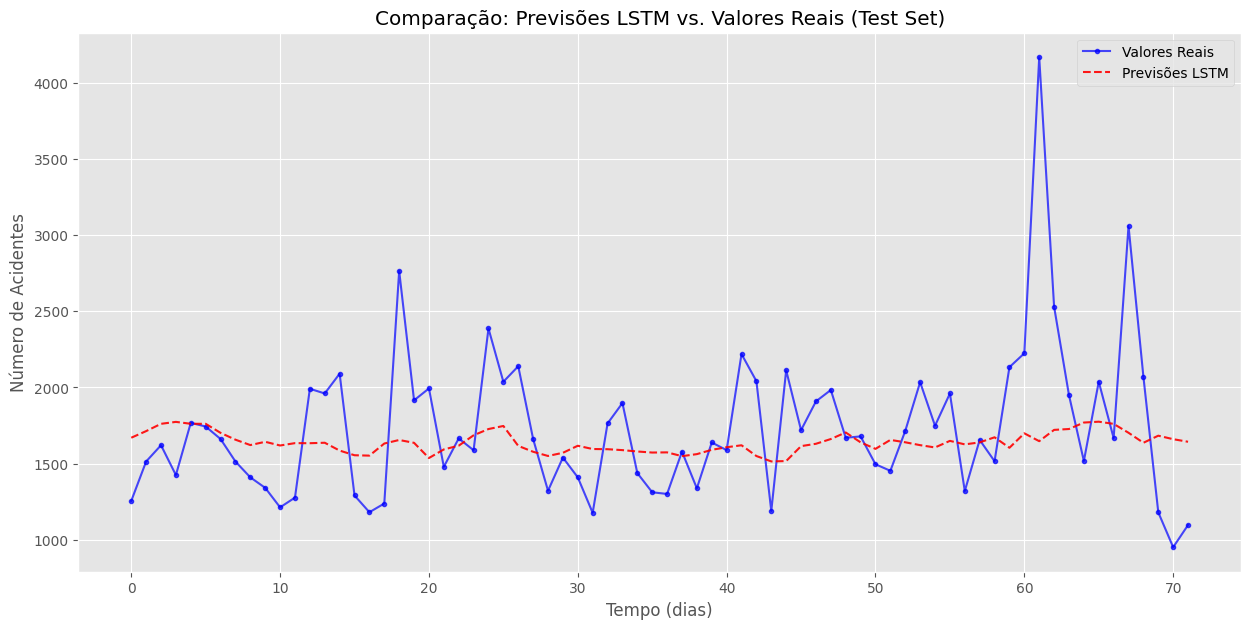

In [43]:
# -------------------------------------------------------------------
# AVALIAÇÃO DO MODELO
# -------------------------------------------------------------------
# 1. Fazer previsões
y_pred_scaled = model.predict(X_test)

# 2. Desnormalizar os dados

# Criar um array "dummy" com o formato original (n_samples, n_features)
dummy_array = np.zeros((len(y_pred_scaled), n_features))
# Colocar as previsões na coluna do target (coluna 0)
dummy_array[:, target_col_index] = y_pred_scaled.flatten()
# Inverter a transformação
y_pred = scaler.inverse_transform(dummy_array)[:, target_col_index]

# Fazer o mesmo para o y_test original
dummy_array_test = np.zeros((len(y_test), n_features))
dummy_array_test[:, target_col_index] = y_test.flatten()
y_test_orig = scaler.inverse_transform(dummy_array_test)[:, target_col_index]


# 3. Calcular métricas (RMSE, MAE)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
mae = mean_absolute_error(y_test_orig, y_pred)

print(f"--- Métricas de Avaliação no Conjunto de Teste ---")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"MAE (Mean Absolute Error): {mae:.2f}")

# 4. Visualizar as previsões vs. real
plt.figure(figsize=(15, 7))
plt.plot(y_test_orig, label='Valores Reais', color='blue', marker='.', alpha=0.7)
plt.plot(y_pred, label='Previsões LSTM', color='red', alpha=0.9, linestyle='--')
plt.title('Comparação: Previsões LSTM vs. Valores Reais (Test Set)')
plt.xlabel('Tempo (dias)')
plt.ylabel('Número de Acidentes')
plt.legend()
plt.show()

In [39]:
# -------------------------------------------------------------------
# SALVAR O MODELO
# -------------------------------------------------------------------
model_filename = 'lstm_acidentes.keras'
model.save(model_filename)
print(f"Modelo salvo como '{model_filename}'")

# Código para fazer o download do arquivo no Google Colab
try:
    from google.colab import files
    files.download(model_filename)
except ImportError:
    print("Use 'files.download' apenas no Google Colab.")

Modelo salvo como 'lstm_acidentes.keras'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>